## Let's Talk Linear Regression 


## Loading and Understanding Data

In [14]:
# import relevant modules
import pandas as pd
import numpy as np
import quandl, math

# Machine Learning
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

#Visualization
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [15]:
# Get unique quandl key by creating a free account with quandl 
# And directly load financial data from GOOGL

quandl.ApiConfig.api_key = 'q-UWpMLYsWKFejy5y-4a'
df = quandl.get('WIKI/GOOGL')

In [17]:
# Getting a peek into data
print(df.columns)
print(df.head(2))

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')
              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   

            Adj. Volume  
Date                     
2004-08-19   44659000.0  
2004-08-20   22834300.0  


As you would notice the data has very strongly dependent features such as 'Open' and 'Adj. Open'. Let's deal with only adjusted data as they are largely self contained before we even get into feature engineering. We can also discard any other column that are irrelevant for or prediction.

In [18]:
# Discarding features that aren't useful
df = df[['Adj. Open','Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
print(df.head(2))

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume
Date                                                                
2004-08-19  50.159839  52.191109  48.128568   50.322842   44659000.0
2004-08-20  50.661387  54.708881  50.405597   54.322689   22834300.0


## Feature Engineering
We can refine our features even further based on our general understanding of financial data.
For instance, instead of dealing with High and Low separately, we could create volatility percentage as a new feature.
$$HL\_PCT = \frac{high - low}{low*100}$$
Similarly, 
$$PCT\_CHNG = \frac{close - open}{open*100}$$

In [19]:
# define a new feature, HL_PCT
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/(df['Adj. Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Adj. Close'] - df['Adj. Open'])/(df['Adj. Open']*100)

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHNG', 'Adj. Volume']]

print(df.head(3))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume
Date                                                   
2004-08-19   50.322842  0.000844  0.000032   44659000.0
2004-08-20   54.322689  0.000854  0.000723   22834300.0
2004-08-23   54.869377  0.000406 -0.000123   18256100.0


In [20]:
# Check which columns have missing data
for column in df.columns:
    if np.any(pd.isnull(df[column])) == True:
        print(column)

It seems like we don't have any missing or NaN data, in case we had that we need to replace them with something to be able to run our machine learning algorithm.

One common way to do so is as follows:  
``` python 
df.fillna(-99999, inplace = True) 
```

In [21]:
# pick a forecast column
forecast_col = 'Adj. Close'

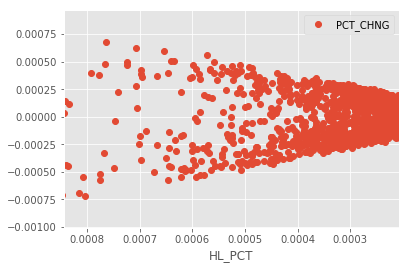

In [22]:
# Plot features

df.plot( x = 'HL_PCT', y = 'PCT_CHNG', style = 'o')

## Machine Learning

### Creating Features and Label

In [23]:
# Chosing 1% of total days as forecast, so length of forecast data is 0.01*length
print('length = ',len(df))
forecast_out = math.ceil(0.01*len(df))

length =  3173


In [24]:
# Creating label and shifting data as per 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))

            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume      label
Date                                                              
2004-08-19   50.322842  0.000844  0.000032   44659000.0  69.399229
2004-08-20   54.322689  0.000854  0.000723   22834300.0  68.752232


In [25]:
# If we look at the tail, it consists of forecast_out rows with NAN in Label column 
print(df.tail(2))
print('\n')
# We can simply drop those rows
df.dropna(inplace=True)
print(df.tail(2))


            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume  label
Date                                                          
2017-03-24      835.14  0.000180 -0.000081    2080936.0    NaN
2017-03-27      838.51  0.000207  0.000126    1922073.0    NaN


            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume   label
Date                                                           
2017-02-07      829.23  0.000105  0.000045    1666605.0  835.14
2017-02-08      829.88  0.000111 -0.000008    1302225.0  838.51


In [26]:
# Define features (X) and Label (y)
# For X drop label and index
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])
print('X[1,:] = ', X[1,:])
print('y[1] = ',y[1])
print('length of X and y: ', len(X), len(y))

X[1,:] =  [  5.43226889e+01   8.53731343e-04   7.22700723e-04   2.28343000e+07]
y[1] =  68.7522315524
length of X and y:  3141 3141


### Scaling the features

In [27]:
# Use skalearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.53267343  4.28431268  4.71482083  1.72383078]


### Creating Training and Test Sets

Using cross validation basically shuffles the data and according to our test_size criteria, splits the data into test and training data.

In [28]:
# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  2512 629


### Using Linear Regression
Now time to use linear regression. I first Split the data into 80% of training data and 20% of test data. Used Linear regression to train and test data. Finally, I tested the accuracy of our model on the test data.

In [29]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.97056490127


### Using SVM Regression

It seems like Linear regression did fairly well on the test data set. I also wanted to check another regression algorithm (support vector regression) just out of curiosity. This doesn't do as well as the linear regression, but is a lot more versatile and would be useful in other more complex cases.

In [30]:
# Train
clf2 = svm.SVR()
clf2.fit(X_train,y_train)
# Test
accuracy = clf2.score(X_test, y_test)
print("Accuracy of SVM: ", accuracy)

Accuracy of SVM:  0.81455446426
